In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
from knee_stress_predict.config import raw_data_dir, processed_data_dir
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

## Load data


In [2]:
data_set_name = "set_3"
train_file_path = Path.joinpath(processed_data_dir, data_set_name,  "train_cleaned.csv")
test_file_path = Path.joinpath(processed_data_dir, data_set_name,  "test_cleaned.csv")
train_data = pd.read_csv(train_file_path).drop('Unnamed: 0', axis=1)
test_data = pd.read_csv(test_file_path).drop('Unnamed: 0', axis=1)

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27715 entries, 0 to 27714
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Code                           27715 non-null  object 
 1   Patella_PN                     27715 non-null  int64  
 2   Femur_PN                       27715 non-null  int64  
 3   Tibia_PN                       27715 non-null  int64  
 4   Patella_Car_PN                 27715 non-null  int64  
 5   Femur_Car_PN                   27715 non-null  int64  
 6   Tibia_M_Car_PN                 27715 non-null  int64  
 7   Tibia_L_Car_PN                 27715 non-null  int64  
 8   Patella_volume                 27715 non-null  float64
 9   Femur_volume                   27715 non-null  float64
 10  Tibia_volume                   27715 non-null  float64
 11  Patella_Car_volume             27715 non-null  float64
 12  Femur_Car_volume               27715 non-null 

## Drop unnecessary columns

We need to delete "lat_Max_all_frames" and "medlat_Max_all_frames" since these features are for maximal pressure metrtic only. In this notebook, we are more concentrated on specific time frame, which are: "Max_tib_lat_contact_pressure" and "Max_tib_med_contact_pressure"

In [4]:
train_datasets = train_data.drop(["lat_Max_all_frames", "med_Max_all_frames"], axis=1)
test_datasets = test_data.drop(["lat_Max_all_frames", "med_Max_all_frames"], axis=1)

In [5]:
test_datasets[test_datasets["Max_tib_lat_contact_pressure"].isna()]

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure


In [6]:
test_datasets

,Code,Patella_PN,Femur_PN,Tibia_PN,Patella_Car_PN,Femur_Car_PN,Tibia_M_Car_PN,Tibia_L_Car_PN,Patella_volume,Femur_volume,...,femur_gap_dist,Max_dist_femur_tibia_lat_car,Min_dist_femur_tibia_lat_car,Mean_dist_femur_tibia_lat_car,Max_dist_femur_tibia_med_car,Min_dist_femur_tibia_med_car,Mean_dist_femur_tibia_med_car,frame,Max_tib_med_contact_pressure,Max_tib_lat_contact_pressure
0,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,0,11.121101,7.002541
1,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,1,11.298099,5.670395
2,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,2,10.751015,6.178009
3,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,3,10.151806,6.332067
4,9087863M12,1012,4339,2724,3400,17045,2840,2840,29331.968623,258414.715255,...,17.180449,12.178187,1.852458,6.176293,9.838347,1.24836,5.243077,4,10.463828,7.037964
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6984,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,236,6.439220,9.115008
6985,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,237,6.498964,8.830239
6986,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,238,6.827004,9.140951
6987,9802877M12,843,3910,3065,4795,22215,2840,2840,21222.626105,218472.551214,...,19.691313,17.402953,3.002287,7.321837,12.228509,1.44370,5.174367,239,7.532119,9.149543


In [7]:
def get_tframe_dataset(tframe_num, dataset):
    tframe_dataset = dataset[dataset['frame'] == tframe_num]
    return tframe_dataset

In [8]:
tframe_nums = range(0, 241, 1)

#Create a dictionary that contains 10 timeframes

train_datasets = {}
for tframe_num in tframe_nums:
    train_datasets[tframe_num] = get_tframe_dataset(tframe_num, train_data)

test_datasets = {}
for tframe_num in tframe_nums:
    test_datasets[tframe_num] = get_tframe_dataset(tframe_num, test_data)


## Simple benchmark MSE

In [9]:
mse_simple = pd.DataFrame(columns=['frame', 'med_benchmark_MSE', 'lat_benchmark_MSE'])

for key, values in train_datasets.items():
    med_tibia_predicted = train_datasets[key]['Max_tib_med_contact_pressure'].mean()
    mse_med = ((test_datasets[key]['Max_tib_med_contact_pressure'] - med_tibia_predicted)**2).mean()

    lat_tibia_predicted = train_datasets[key]['Max_tib_lat_contact_pressure'].mean()
    mse_lat = ((test_datasets[key]['Max_tib_lat_contact_pressure'] - lat_tibia_predicted)**2).mean()
    mse_timeframe = { 'frame': key,  'med_benchmark_MSE': mse_med, 'lat_benchmark_MSE': mse_lat }

    mse_simple = mse_simple.append(mse_timeframe, ignore_index=True)

In [10]:
mse_simple

,frame,med_benchmark_MSE,lat_benchmark_MSE
0,0.0,3.036412,2.854782
1,1.0,3.404284,2.376109
2,2.0,3.479863,2.557526
3,3.0,4.036219,2.344548
4,4.0,4.179256,2.225914
...,...,...,...
236,236.0,5.273668,3.292617
237,237.0,5.148064,3.249958
238,238.0,5.659090,3.584436
239,239.0,5.943313,4.431046


## Random Forest

In [11]:
mse_rf = pd.DataFrame(columns=['frame', 'med_rf_MSE', 'lat_rf_MSE'])

for key,value in train_datasets.items():
    out_col = ['Max_tib_med_contact_pressure', 'Max_tib_lat_contact_pressure']
    feat_cols = list(set(list(train_datasets[key].columns)) - set(out_col) - {'Code', 'frame'})
    train_x = train_datasets[key][feat_cols]
    train_y_med = train_datasets[key][['Max_tib_med_contact_pressure']]
    train_y_lat = train_datasets[key][['Max_tib_lat_contact_pressure']]

    test_x = test_datasets[key][feat_cols]
    test_y_med = test_datasets[key][['Max_tib_med_contact_pressure']]
    test_y_lat = test_datasets[key][['Max_tib_lat_contact_pressure']]


    rf_model_med = RandomForestRegressor()
    rf_model_med.fit(train_x, train_y_med)
    yhat_med = rf_model_med.predict(test_x)
    mse_med = mean_squared_error(yhat_med, test_y_med)


    rf_model_lat = RandomForestRegressor()
    rf_model_lat.fit(train_x, train_y_lat)
    yhat_lat = rf_model_lat.predict(test_x)
    mse_lat = mean_squared_error(yhat_lat, test_y_lat)

    mse_timeframe = { 'frame': key,  'med_rf_MSE': mse_med, 'lat_rf_MSE': mse_lat }

    mse_rf = mse_rf.append(mse_timeframe, ignore_index=True)

In [12]:
mse_rf

,frame,med_rf_MSE,lat_rf_MSE
0,0.0,3.104030,2.324917
1,1.0,3.489851,2.352080
2,2.0,3.522259,2.329075
3,3.0,4.122554,1.993453
4,4.0,3.949690,1.954697
...,...,...,...
236,236.0,5.287529,8.975674
237,237.0,4.833613,6.810926
238,238.0,5.927268,8.205392
239,239.0,5.866069,13.960300


## Lasso

In [13]:
mse_lasso = pd.DataFrame(columns=['frame', 'med_lasso_MSE', 'lat_lasso_MSE'])

for key,value in train_datasets.items():
    out_col = ['Max_tib_med_contact_pressure', 'Max_tib_lat_contact_pressure']
    feat_cols = list(set(list(train_datasets[key].columns)) - set(out_col) - {'Code', 'frame'})
    train_x = train_datasets[key][feat_cols]
    train_y_med = train_datasets[key][['Max_tib_med_contact_pressure']]
    train_y_lat = train_datasets[key][['Max_tib_lat_contact_pressure']]

    test_x = test_datasets[key][feat_cols]
    test_y_med = test_datasets[key][['Max_tib_med_contact_pressure']]
    test_y_lat = test_datasets[key][['Max_tib_lat_contact_pressure']]

    lasso_model_med = linear_model.Lasso(alpha=100, max_iter=1000000)
    lasso_model_med.fit(train_x, train_y_med)
    yhat_med = lasso_model_med.predict(test_x)
    mse_med = mean_squared_error(yhat_med, test_y_med)

    lasso_model_lat = linear_model.Lasso(alpha=100, max_iter=1000000)
    lasso_model_lat.fit(train_x, train_y_lat)
    yhat_lat = lasso_model_lat.predict(test_x)
    mse_lat = mean_squared_error(yhat_lat, test_y_lat)
    mse_timeframe = { 'frame': key,  'med_lasso_MSE': mse_med, 'lat_lasso_MSE': mse_lat }

    mse_lasso = mse_lasso.append(mse_timeframe, ignore_index=True)

In [14]:
mse_lasso

,frame,med_lasso_MSE,lat_lasso_MSE
0,0.0,3.621919,2.644838
1,1.0,3.801670,2.337135
2,2.0,3.826572,2.506904
3,3.0,4.404460,2.284510
4,4.0,4.594347,2.213669
...,...,...,...
236,236.0,5.854359,17.368710
237,237.0,5.426150,15.263737
238,238.0,6.112836,20.192782
239,239.0,6.288065,34.809808


## Comparison

In [15]:
mse = mse_simple.merge(mse_rf, on='frame')
mse = mse.merge(mse_lasso, on='frame')

In [16]:
mse

,frame,med_benchmark_MSE,lat_benchmark_MSE,med_rf_MSE,lat_rf_MSE,med_lasso_MSE,lat_lasso_MSE
0,0.0,3.036412,2.854782,3.104030,2.324917,3.621919,2.644838
1,1.0,3.404284,2.376109,3.489851,2.352080,3.801670,2.337135
2,2.0,3.479863,2.557526,3.522259,2.329075,3.826572,2.506904
3,3.0,4.036219,2.344548,4.122554,1.993453,4.404460,2.284510
4,4.0,4.179256,2.225914,3.949690,1.954697,4.594347,2.213669
...,...,...,...,...,...,...,...
236,236.0,5.273668,3.292617,5.287529,8.975674,5.854359,17.368710
237,237.0,5.148064,3.249958,4.833613,6.810926,5.426150,15.263737
238,238.0,5.659090,3.584436,5.927268,8.205392,6.112836,20.192782
239,239.0,5.943313,4.431046,5.866069,13.960300,6.288065,34.809808


[Text(0.5, 1.0, 'Mean Squared Error of \n the Medial Cartilage Contact Pressure Prediction'),
 Text(0.5, 0, 'time frame'),
 Text(0, 0.5, 'MSE')]

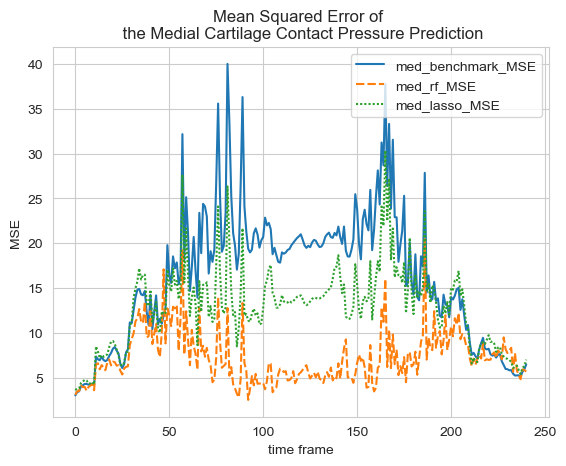

In [17]:
sns.lineplot(data=mse[["med_benchmark_MSE", "med_rf_MSE", "med_lasso_MSE"]]).\
    set(
        title='Mean Squared Error of \n the Medial Cartilage Contact Pressure Prediction',
        xlabel = "time frame", ylabel="MSE"
        )

[Text(0.5, 1.0, 'Mean Squared Error of \n the Lateral Cartilage Contact Pressure Prediction'),
 Text(0.5, 0, 'time frame'),
 Text(0, 0.5, 'MSE')]

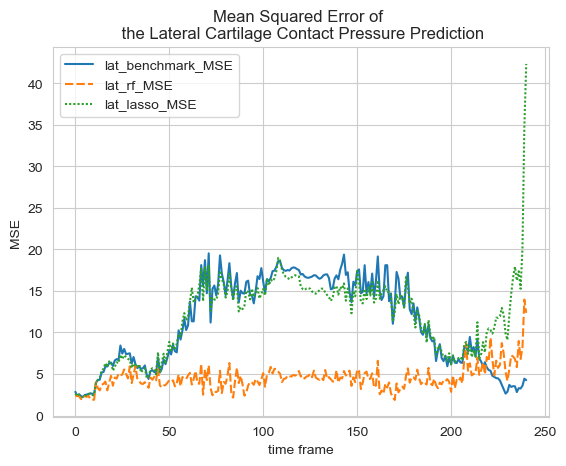

In [18]:
sns.lineplot(data=mse[["lat_benchmark_MSE", "lat_rf_MSE", "lat_lasso_MSE"]]).\
    set(
        title='Mean Squared Error of \n the Lateral Cartilage Contact Pressure Prediction',
        xlabel = "time frame", ylabel="MSE"
        )